# QSVM for AdHoc Dataset
## Prepare data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import Aer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
from qiskit.providers.ibmq import least_busy
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel, FidelityQuantumKernel
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.svm import SVC

In [3]:
df = pd.read_csv('datasets/adhoc_1k.csv', index_col=0)
df

,feature_1,feature_2,label
0,3.832743,5.277876,0.0
1,5.906194,6.094690,0.0
2,3.895575,5.026548,0.0
3,2.701770,4.963716,0.0
4,4.335398,3.895575,0.0
...,...,...,...
995,3.330088,2.827433,1.0
996,0.188496,2.010619,1.0
997,1.884956,4.209734,1.0
998,5.026548,5.780530,1.0


In [4]:
feature_dimension = df.shape[1] - 1
print(f"Feature dimension: {feature_dimension}")

Feature dimension: 2


In [44]:
# Split the data into training and test sets
all_features = df.copy()
all_labels = all_features.pop('label')

train = df.sample(frac=0.75, random_state=42)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

## Find best SVM setting

Try different kernels with different settings and plot the winning circuit

In [45]:
algorithm_globals.random_seed = 42
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [46]:
# Specify kernel experiments:

kernels = [
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=3, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=4, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='sca')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='sca')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=3, entanglement='sca')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=4, entanglement='sca')),
                  quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['ZZ']),
    #               quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['Z', 'XX']),
    #               quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear', paulis=['ZZ']),
    #               quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear', paulis=['Z', 'XX']),
    #               quantum_instance=quantum_instance),
    # FidelityQuantumKernel(feature_map=ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear'),
    #                       fidelity=ComputeUncompute(sampler=Sampler())),
    # FidelityQuantumKernel(feature_map=ZZFeatureMap(feature_dimension=feature_dimension, reps=3, entanglement='linear'),
    #                       fidelity=ComputeUncompute(sampler=Sampler())),
    # FidelityQuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['Z', 'XX']),
    #                       fidelity=ComputeUncompute(sampler=Sampler())),
    # FidelityQuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['Z', 'XX']),
    #                       fidelity=ComputeUncompute(sampler=Sampler()))
]

In [7]:
# svc = SVC()
# search = RandomizedSearchCV(svc, cv=10, n_iter=16, n_jobs=-1, refit=True,
#                             param_distributions={'kernel': [kernel.evaluate for kernel in kernels]})
# # search.fit(train_features, train_labels)
# search.fit(all_features, all_labels)

Best is kernel 1 using ZZFeatureMap with 2 reps and linear entanglement


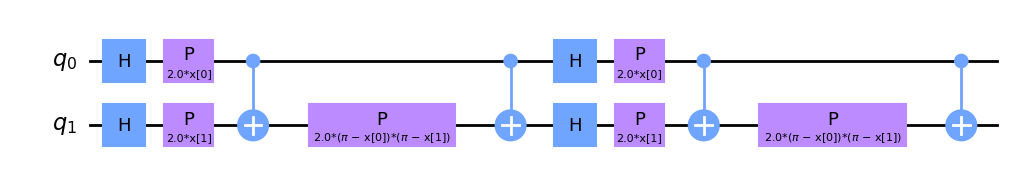

In [47]:
# best_kernel = search.best_params_['kernel'].__self__
# print(f"Best is kernel {kernels.index(best_kernel)} using {best_kernel.feature_map.__class__.__name__} with {best_kernel.feature_map.reps} reps and {best_kernel.feature_map.entanglement} entanglement")
# svc = search.best_estimator_
# best_kernel.feature_map.decompose().draw(output='mpl')

## Train the winning kernel circuit using 10-fold cross validation

In [47]:
best_kernel = kernels[1] # Index from output above
svc = SVC(kernel=best_kernel.evaluate)

results = cross_validate(svc, train_features, train_labels, cv=10, n_jobs=-1, return_estimator=True, return_train_score=True)

/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/l

In [48]:
resulting_models = results['estimator']
total_times = results['fit_time'] + results['score_time']
print(f"Time consumed for each SVC: {total_times}, mean: {total_times.mean()}")

Time consumed for each SVC: [737.18501306 713.121562   716.16028905 737.01374483 733.99025798
 743.94276977 727.53176427 735.01345181 738.07633495 693.32457805], mean: 727.5359765768051


In [ ]:
# Calculate accuracy on testing dataset

import concurrent

with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    for i, model in enumerate(resulting_models):
        futures.append(executor.submit(model.score, test_features, test_labels))
    executor.shutdown(wait=True)
    accuracies = np.array([future.result() for future in futures])
accuracies

/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/l

### Training evaluation

In [ ]:
print(', '.join(map(lambda accuracy: f'{accuracy:.2f}', accuracies)))
print('mean: {:.2f}, std: {:.2f}, mean training time: {:.0f}s'.format(accuracies.mean(), accuracies.std(),
                                                                          np.array(total_times).mean()))

---
### Classical Implementation

In [16]:
classical_svc = SVC(kernel='rbf')
classical_results = cross_validate(classical_svc, train_features, train_labels, cv=10, n_jobs=-1, return_estimator=True, return_train_score=True)
classical_results

{'fit_time': array([1.01363397, 1.05535293, 1.0829761 , 1.01871419, 1.06807494,
        1.03795409, 1.05779886, 1.01118016, 0.99302316, 1.01628613]),
 'score_time': array([0.15134907, 0.17013693, 0.14834285, 0.16768384, 0.12149882,
        0.16383386, 0.15445209, 0.13816762, 0.2405951 , 0.15269089]),
 'estimator': [SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC()],
 'test_score': array([0.70266667, 0.672     , 0.67066667, 0.68933333, 0.66266667,
        0.672     , 0.69866667, 0.69066667, 0.67733333, 0.672     ]),
 'train_score': array([0.67792593, 0.68785185, 0.68237037, 0.68666667, 0.68518519,
        0.68592593, 0.68637037, 0.68148148, 0.68118519, 0.68666667])}

In [17]:
print(f"Classical mean SVC score: {classical_results['test_score'].mean()} with std. deviation {classical_results['test_score'].std()}")

Classical mean SVC score: 0.6808 with std. deviation 0.012819429697836707


In [18]:
classical_scores = np.array([model.score(test_features, test_labels) for model in classical_results['estimator']])
classical_total_times = classical_results['fit_time'] + classical_results['score_time']
print(', '.join(map(lambda accuracy: f'{accuracy:.2f}', classical_scores)))
print('mean: {:.2f}, std: {:.2f}, mean training time: {:.0f}s'.format(classical_scores.mean(), classical_scores.std(),
                                                                          np.array(classical_total_times).mean()))

0.66, 0.66, 0.66, 0.66, 0.66, 0.67, 0.67, 0.66, 0.66, 0.66
mean: 0.66, std: 0.00, mean training time: 1s


---
### Run on real quantum computer

In [ ]:
from qiskit import IBMQ

# Best kernel should already be evaluated and set (in the above code cell)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='zhaw-1')
backend = least_busy(provider.backends(simulator=True))
print(f"Chosen backend: {backend}")
best_model = resulting_models[np.argmax(accuracies)]
best_model.kernel.__self__.quantum_instance = QuantumInstance(backend, shots=1024)
score = best_model.score(test_features, test_labels)
print(f"Quantum score: {score}")
